In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import statsmodels.formula.api as smf

# GS

In [21]:
grm_file = "/data/jerrylee/data/GS/GRM/for_gcta/GS_GWAS"
gcta_file = "/data/jerrylee/tools/gcta64"
pheno_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/GS/phenotype"
out_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/GS/w_geno"

In [22]:
fns = os.listdir(pheno_path)
len(fns)

40

In [8]:
for fn in fns:
    pheno = fn.split(".")[0]
    pheno_file = os.path.join(pheno_path, fn)
    out_file = f"{out_path}/{pheno}"
    cmd = f"{gcta_file} --HEreg --grm {grm_file} --pheno {pheno_file} --out {out_file}"
    os.system(cmd)

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version 1.94.0 beta Linux
* (C) 2010-present, Jian Yang, The University of Queensland
* Please report bugs to Jian Yang <jian.yang.qt@gmail.com>
*******************************************************************
Analysis started at 12:22:47 KST on Tue Nov 26 2024.
Hostname: h4

Accepted options:
--HEreg
--grm /data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/A/GS.eA
--pheno /data/jerrylee/pjt/BIGFAM.v.2.0/data/GS/phenotype/QT_interval.phen
--out /data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/GS/QT_interval

Note: This is a multi-thread program. You could specify the number of threads by the --thread-num option to speed up the computation if there are multiple processors in your machine.

Reading IDs of the GRM from [/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/A/GS.eA.grm.id].
19982 IDs are read from [/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/A/GS.eA

# UKB

In [23]:
grm_path = "/data/jerrylee/data/UKB/grm_rel"
gcta_file = "/data/jerrylee/tools/gcta64"
pheno_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/phenotype"
out_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/UKB"

In [24]:
fns = os.listdir(pheno_path)
len(fns)

106

In [25]:
for fn in fns:
    pheno = fn.split(".")[0]
    pheno_file = os.path.join(pheno_path, fn)
    
    for dor in [1, 2, 3]:
        grm_file = f"{grm_path}/DOR{dor}_chrALL"
        out_file = f"{out_path}/{pheno}.{dor}"
        cmd = f"{gcta_file} --HEreg --grm {grm_file} --pheno {pheno_file} --out {out_file}"
        os.system(cmd)

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version 1.94.0 beta Linux
* (C) 2010-present, Jian Yang, The University of Queensland
* Please report bugs to Jian Yang <jian.yang.qt@gmail.com>
*******************************************************************
Analysis started at 14:27:46 KST on Tue Nov 26 2024.
Hostname: h4

Accepted options:
--HEreg
--grm /data/jerrylee/data/UKB/grm_rel/DOR1_chrALL
--pheno /data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/phenotype/White_blood_cell__leukocyte__count.phen
--out /data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/UKB/White_blood_cell__leukocyte__count.1

Note: This is a multi-thread program. You could specify the number of threads by the --thread-num option to speed up the computation if there are multiple processors in your machine.

Reading IDs of the GRM from [/data/jerrylee/data/UKB/grm_rel/DOR1_chrALL.grm.id].
17057 IDs are read from [/data/jerrylee/data/UKB/grm_rel/DOR1_c

# merge

In [91]:
path_gs = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/GS"
gs_fns = os.listdir(path_gs)
gs_fns = [fn for fn in gs_fns if fn.endswith(".HEreg")]
len(gs_fns)

40

In [92]:
# 결과를 추출하는 함수 정의
def extract_he_results(file_path):
    df = pd.read_csv(file_path, sep='\s+', skiprows=1)
    
    results = {
        "HE-CP": {"estimate": df.iloc[1, 1], "std_error": df.iloc[1, 3]},
        "HE-SD": {"estimate": df.iloc[5, 1], "std_error": df.iloc[5, 3]}
    }
    
    results = pd.DataFrame(results).T.reset_index()
    results = results.rename(columns={'index': 'Method'})
    return results
    

# 결과를 저장할 데이터프레임 생성
df_gs = pd.DataFrame()

# 모든 파일에 대해 결과 추출
for fn in gs_fns:
    pheno = fn.split('.')[0]  # 파일명에서 표현형 이름 추출
    file_path = os.path.join(path_gs, fn)
    
    # 결과 추출
    results = extract_he_results(file_path)
    results["phenotype"] = pheno
    df_gs = pd.concat([df_gs, results], ignore_index=True)

df_gs["cohort"] = "GS"

In [93]:
path_ukb = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/UKB"
ukb_fns = os.listdir(path_ukb)
ukb_fns = [fn for fn in ukb_fns if fn.endswith(".HEreg")]
print(len(ukb_fns))

phenos = []
for fn in ukb_fns:
    pheno = fn.split('.')[0]
    phenos.append(pheno)
phenos = list(set(phenos))
print(len(phenos))

318
106


In [95]:
def meta_analyze_he_results(res_dict):
    def perform_ivw_meta(estimates, standard_errors):
        # float 타입으로 명시적 변환
        estimates = estimates.astype(float)
        standard_errors = standard_errors.astype(float)
        
        weights = 1 / (standard_errors ** 2)
        meta_estimate = np.sum(estimates * weights) / np.sum(weights)
        meta_se = np.sqrt(1 / np.sum(weights))
        return meta_estimate, meta_se
    
    # HE-CP 메타분석
    he_cp_estimates = np.array([float(res_dict[i].loc[res_dict[i]['Method'] == 'HE-CP', 'estimate'].values[0]) 
                               for i in res_dict.keys()])
    he_cp_ses = np.array([float(res_dict[i].loc[res_dict[i]['Method'] == 'HE-CP', 'std_error'].values[0]) 
                          for i in res_dict.keys()])
    he_cp_meta_est, he_cp_meta_se = perform_ivw_meta(he_cp_estimates, he_cp_ses)
    
    # HE-SD 메타분석
    he_sd_estimates = np.array([float(res_dict[i].loc[res_dict[i]['Method'] == 'HE-SD', 'estimate'].values[0]) 
                               for i in res_dict.keys()])
    he_sd_ses = np.array([float(res_dict[i].loc[res_dict[i]['Method'] == 'HE-SD', 'std_error'].values[0]) 
                          for i in res_dict.keys()])
    he_sd_meta_est, he_sd_meta_se = perform_ivw_meta(he_sd_estimates, he_sd_ses)
    
    # 결과 데이터프레임 생성
    meta_results = pd.DataFrame({
        'Method': ['HE-CP', 'HE-SD'],
        'estimate': [he_cp_meta_est, he_sd_meta_est],
        'std_error': [he_cp_meta_se, he_sd_meta_se]
    })
    
    return meta_results

# 결과를 저장할 데이터프레임 생성
df_ukb = pd.DataFrame()

# 모든 파일에 대해 결과 추출
for pheno in phenos:
    res_dict = {}
    for dor in [1, 2, 3]:
        fn = f"{path_ukb}/{pheno}.{dor}.HEreg"
            
        # 결과 추출
        res_dict[dor] = extract_he_results(fn)
    
    meta_results = meta_analyze_he_results(res_dict)
    meta_results["phenotype"] = pheno
    df_ukb = pd.concat([df_ukb, meta_results], ignore_index=True)
    
df_ukb["cohort"] = "UKB"

In [96]:
df_ukb

,Method,estimate,std_error,phenotype,cohort
0,HE-CP,0.172624,0.016313,Red_blood_cell__erythrocyte__distribution_width,UKB
1,HE-SD,0.177555,0.046988,Red_blood_cell__erythrocyte__distribution_width,UKB
2,HE-CP,0.071002,0.014845,C-reactive_protein,UKB
3,HE-SD,0.131470,0.064144,C-reactive_protein,UKB
4,HE-CP,0.324991,0.017332,Impedance_of_arm__right_,UKB
...,...,...,...,...,...
207,HE-SD,0.325841,0.044149,Alkaline_phosphatase,UKB
208,HE-CP,0.206136,0.017639,Creatinine,UKB
209,HE-SD,0.256939,0.082333,Creatinine,UKB
210,HE-CP,0.359137,0.017477,Impedance_of_whole_body,UKB


In [97]:
df_mrg = pd.concat([df_gs, df_ukb], ignore_index=True)
df_mrg[["cohort", "phenotype", "Method", "estimate", "std_error"]].sort_values(by=["cohort", "phenotype", "Method"]).to_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/HE/HE.ivw.tsv", index=False,
    sep="\t"
)


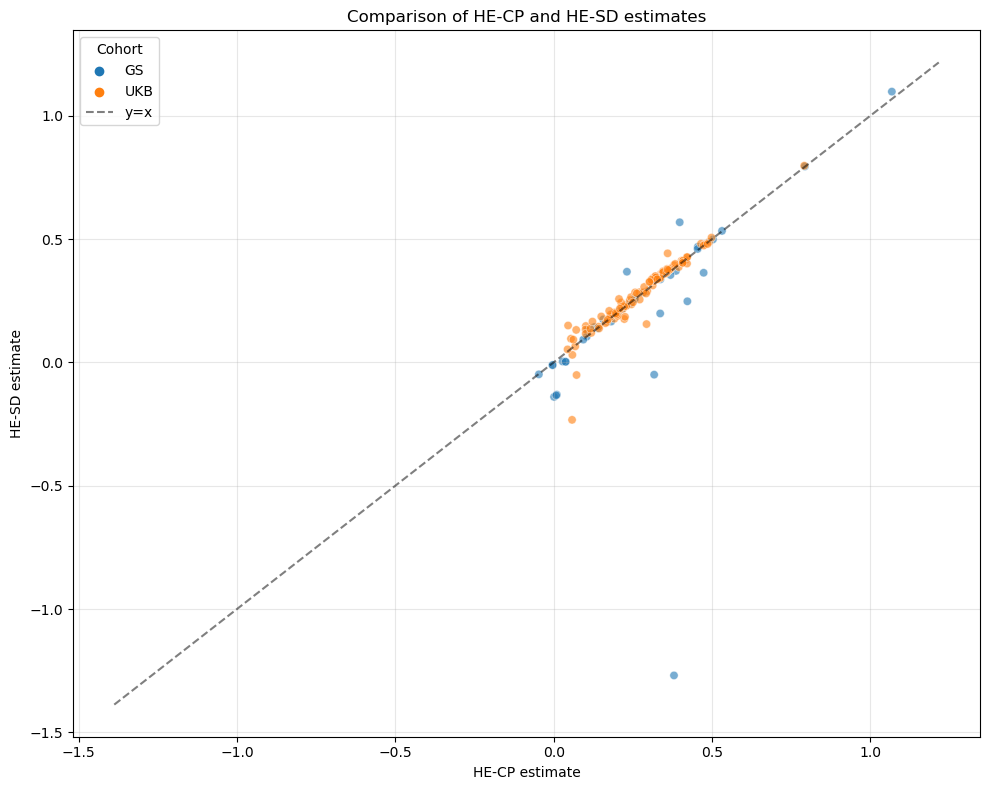

In [99]:
# 데이터 준비
he_cp = df_mrg[df_mrg['Method'] == 'HE-CP'].set_index(['cohort', 'phenotype'])['estimate'].astype(float)
he_sd = df_mrg[df_mrg['Method'] == 'HE-SD'].set_index(['cohort', 'phenotype'])['estimate'].astype(float)

plot_df = pd.DataFrame({
    'HE-CP': he_cp,
    'HE-SD': he_sd
}).reset_index()

# 플롯 생성
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, 
                x='HE-CP', 
                y='HE-SD',
                hue='cohort',
                alpha=0.6)

# 대각선 추가 (y=x 라인)
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]])
]
plt.plot(lims, lims, 'k--', alpha=0.5, label='y=x')

# 플롯 꾸미기
plt.title('Comparison of HE-CP and HE-SD estimates', fontsize=12)
plt.xlabel('HE-CP estimate', fontsize=10)
plt.ylabel('HE-SD estimate', fontsize=10)
plt.legend(title='Cohort')
plt.grid(True, alpha=0.3)

# 플롯 표시
plt.tight_layout()
plt.show()

In [101]:
plot_df.corr()

,HE-CP,HE-SD
HE-CP,1.000000,0.729944
HE-SD,0.729944,1.000000
